In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Load dataset
df = pd.read_csv("All_Beauty.csv")


In [13]:
# Filter: Verified purchases only
df = df[df['verified_purchase'] == True]


In [14]:
# Remove neutral ratings
df = df[df['rating'] != 3]

In [15]:
# Label encoding: 1 = positive (rating >= 4), 0 = negative (rating <= 2)
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [17]:
# Minimal text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)


In [18]:
# Tokenization and padding
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len)


In [19]:
# Labels
labels = df['label'].values


In [20]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [21]:
# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



C:\Users\chien\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.8000 - loss: 0.5191 - val_accuracy: 0.8573 - val_loss: 0.3432
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.8953 - loss: 0.2497 - val_accuracy: 0.8766 - val_loss: 0.2886
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.9343 - loss: 0.1718 - val_accuracy: 0.8931 - val_loss: 0.2551
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.9702 - loss: 0.0946 - val_accuracy: 0.8986 - val_loss: 0.2929
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9775 - loss: 0.0731 - val_accuracy: 0.8981 - val_loss: 0.3222


In [23]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")



71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8937 - loss: 0.3552

Test Accuracy: 0.9022


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification report
print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       434
           1       0.93      0.95      0.94      1835

    accuracy                           0.90      2269
   macro avg       0.85      0.82      0.83      2269
weighted avg       0.90      0.90      0.90      2269


Confusion Matrix:
[[ 299  135]
 [  87 1748]]


In [25]:
# Plot training history
plt.figure(figsize=(12, 5))



<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

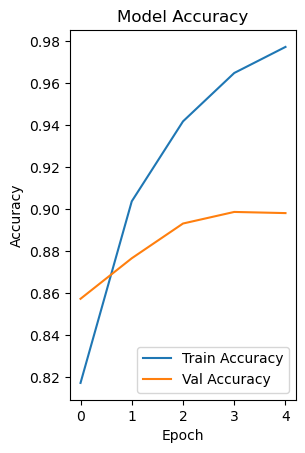

In [26]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



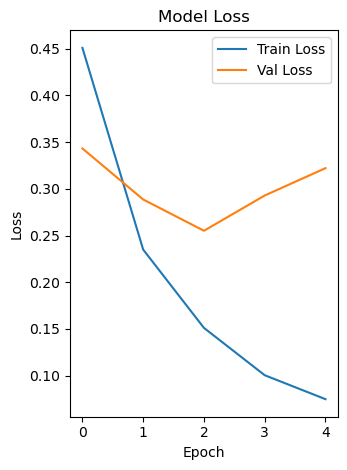

In [27]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Predict sentiment on new/unseen reviews

# Example: list of new reviews
new_reviews = [
    "This product is amazing and worked exactly as expected!",
    "Terrible quality. I want a refund.",
    "It's okay, not the best but not the worst either."
]

# Clean new reviews using the same cleaning function
new_reviews_cleaned = [clean_text(text) for text in new_reviews]

# Tokenize and pad
new_sequences = tokenizer.texts_to_sequences(new_reviews_cleaned)
new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict
predictions = model.predict(new_padded)
predicted_labels = (predictions > 0.5).astype("int32")

# Output predictions
for review, score, label in zip(new_reviews, predictions, predicted_labels):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Review: \"{review}\"\n→ Predicted Sentiment: {sentiment} ({score[0]:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Review: "This product is amazing and worked exactly as expected!"
→ Predicted Sentiment: Positive (0.7808)

Review: "Terrible quality. I want a refund."
→ Predicted Sentiment: Positive (0.7808)

Review: "It's okay, not the best but not the worst either."
→ Predicted Sentiment: Positive (0.7808)

